# Multiclass Sentiment Analysis - Three Pipeline Comparison

This notebook implements and compares three different approaches for multiclass sentiment analysis:
1. **Word2Vec + Multinomial Logistic Regression**
2. **Word2Vec + MLP**
3. **MLP with Embedding from Scratch**

Dataset: [Sp1786/multiclass-sentiment-analysis-dataset](https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset)

## 1. Import Required Libraries

In [357]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Word2Vec
from gensim.models import Word2Vec

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# HuggingFace datasets
from datasets import load_dataset

# Set Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Load and Explore the Dataset

In [358]:
# Load the dataset from HuggingFace
print("Loading dataset from HuggingFace...")
dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")

# Convert to pandas DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")
print("\nFirst few rows:")
train_df.head()

Loading dataset from HuggingFace...
Train dataset shape: (31232, 4)
Test dataset shape: (5206, 4)

First few rows:


,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


Dataset Information:
Columns: ['id', 'text', 'label', 'sentiment']

Data types:
id            int64
text         object
label         int64
sentiment    object
dtype: object

Missing values:
id           0
text         0
label        0
sentiment    0
dtype: int64

Class distribution:
label
0     9105
1    11649
2    10478
Name: count, dtype: int64


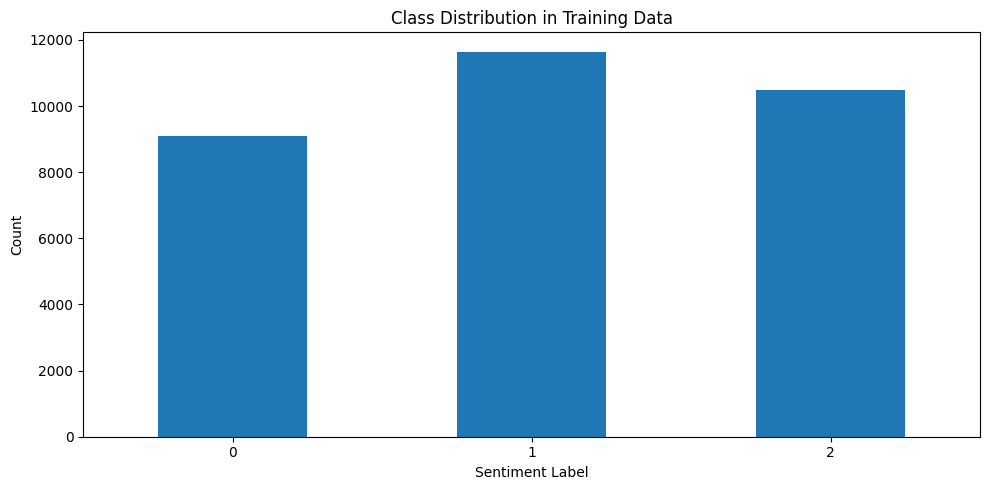

In [359]:
# Explore the dataset
print("Dataset Information:")
print(f"Columns: {train_df.columns.tolist()}")
print(f"\nData types:\n{train_df.dtypes}")
print(f"\nMissing values:\n{train_df.isnull().sum()}")
print(f"\nClass distribution:")
print(train_df['label'].value_counts().sort_index())

# Visualize class distribution
plt.figure(figsize=(10, 5))
train_df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Preprocess the Data

In [360]:
def preprocess_text(text):
    """
    Preprocess text data:
    - Handle None/null values
    - Convert to lowercase
    - Remove special characters and numbers
    - Tokenize
    - Remove stopwords
    """
    # Handle None or empty text
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return []
    
    # Convert to string if needed
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return tokens

# Remove rows with null text values
print("Checking for null values...")
print(f"Training data null texts: {train_df['text'].isnull().sum()}")
print(f"Test data null texts: {test_df['text'].isnull().sum()}")

# Apply preprocessing
print("\nPreprocessing training data...")
train_df['tokens'] = train_df['text'].apply(preprocess_text)

print("Preprocessing test data...")
test_df['tokens'] = test_df['text'].apply(preprocess_text)

# Remove rows with empty tokens (if any)
train_df = train_df[train_df['tokens'].apply(len) > 0].reset_index(drop=True)
test_df = test_df[test_df['tokens'].apply(len) > 0].reset_index(drop=True)

print(f"\nAfter preprocessing:")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

print("\nExample of preprocessed text:")
print(f"Original: {train_df['text'].iloc[0]}")
print(f"Tokens: {train_df['tokens'].iloc[0]}")

Checking for null values...
Training data null texts: 0
Test data null texts: 1

Preprocessing training data...
Preprocessing test data...

After preprocessing:
Training data shape: (31106, 5)
Test data shape: (5180, 5)

Example of preprocessed text:
Original: Cooking microwave pizzas, yummy
Tokens: ['cooking', 'microwave', 'pizzas', 'yummy']


## 4. Train Word2Vec Model

In [361]:
# Train Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=train_df['tokens'].tolist(),
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

print(f"Word2Vec model trained!")
print(f"Vocabulary size: {len(w2v_model.wv)}")

# Test the model
test_word = 'good'
if test_word in w2v_model.wv:
    similar_words = w2v_model.wv.most_similar(test_word, topn=5)
    print(f"\nWords most similar to '{test_word}':")
    for word, similarity in similar_words:
        print(f"  {word}: {similarity:.3f}")

Training Word2Vec model...
Word2Vec model trained!
Vocabulary size: 11194

Words most similar to 'good':
  great: 0.849
  well: 0.790
  awesome: 0.776
  nice: 0.746
  cool: 0.735


In [362]:
def get_document_vector(tokens, model, vector_size=100):
    """
    Get document vector by averaging word vectors.
    """
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    
    if len(vectors) == 0:
        return np.zeros(vector_size)
    
    return np.mean(vectors, axis=0)

# Create document vectors for training and test data
print("Creating document vectors...")
X_train_w2v = np.array([get_document_vector(tokens, w2v_model) for tokens in train_df['tokens']])
X_test_w2v = np.array([get_document_vector(tokens, w2v_model) for tokens in test_df['tokens']])

y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"X_train_w2v shape: {X_train_w2v.shape}")
print(f"X_test_w2v shape: {X_test_w2v.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Creating document vectors...
X_train_w2v shape: (31106, 100)
X_test_w2v shape: (5180, 100)
y_train shape: (31106,)
y_test shape: (5180,)


---

## 5. Pipeline 1: Word2Vec + Multinomial Logistic Regression

This pipeline uses:
- **Feature extraction**: Word2Vec embeddings averaged per document
- **Model**: Multinomial Logistic Regression (multi_class='multinomial')
- **Train/Validation Split**: 80/20 split from training data

In [363]:
# Split training data into train and validation sets
X_train_p1, X_val_p1, y_train_p1, y_val_p1 = train_test_split(
    X_train_w2v, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Pipeline 1: Word2Vec + Logistic Regression")
print("=" * 60)
print(f"Training set size: {X_train_p1.shape[0]}")
print(f"Validation set size: {X_val_p1.shape[0]}")
print(f"Test set size: {X_test_w2v.shape[0]}")
print(f"Feature dimension: {X_train_p1.shape[1]}")

Pipeline 1: Word2Vec + Logistic Regression
Training set size: 24884
Validation set size: 6222
Test set size: 5180
Feature dimension: 100


In [364]:
# Train Logistic Regression model
print("\nTraining Logistic Regression model...")
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_p1, y_train_p1)
print("Training completed!")

# Evaluate on validation set
y_val_pred_p1 = lr_model.predict(X_val_p1)
val_accuracy_p1 = accuracy_score(y_val_p1, y_val_pred_p1)

print(f"\n{'='*60}")
print("VALIDATION SET RESULTS")
print(f"{'='*60}")
print(f"Validation Accuracy: {val_accuracy_p1:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_val_p1, y_val_pred_p1))


Training Logistic Regression model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training completed!

VALIDATION SET RESULTS
Validation Accuracy: 0.5887

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.59      0.47      0.53      1818
           1       0.51      0.64      0.57      2313
           2       0.71      0.63      0.67      2091

    accuracy                           0.59      6222
   macro avg       0.60      0.58      0.59      6222
weighted avg       0.60      0.59      0.59      6222




TEST SET RESULTS
Test Accuracy: 0.5902

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.63      0.47      0.54      1542
           1       0.50      0.65      0.57      1912
           2       0.70      0.63      0.66      1726

    accuracy                           0.59      5180
   macro avg       0.61      0.58      0.59      5180
weighted avg       0.60      0.59      0.59      5180



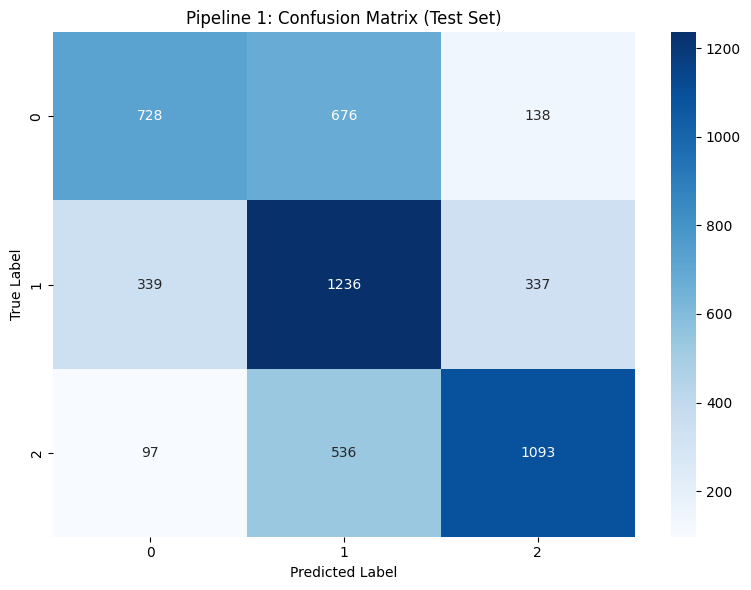

In [365]:
# Evaluate on test set
y_test_pred_p1 = lr_model.predict(X_test_w2v)
test_accuracy_p1 = accuracy_score(y_test, y_test_pred_p1)

print(f"\n{'='*60}")
print("TEST SET RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy_p1:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_p1))

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
cm_p1 = confusion_matrix(y_test, y_test_pred_p1)
sns.heatmap(cm_p1, annot=True, fmt='d', cmap='Blues')
plt.title('Pipeline 1: Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

---
# Pipeline 2: Word2Vec + MLP

## 6. Pipeline 2: Word2Vec + MLP

This pipeline uses:
- **Feature extraction**: Word2Vec embeddings averaged per document
- **Model**: Multi-Layer Perceptron (MLP) with PyTorch
- **Architecture**: Input → Hidden(128) → ReLU → Dropout → Hidden(64) → ReLU → Dropout → Output
- **Train/Validation Split**: 80/20 split from training data

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

             nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

print("MLP model architecture defined!")


MLP model architecture defined!


In [367]:
# Prepare data for Pipeline 2
X_train_p2, X_val_p2, y_train_p2, y_val_p2 = train_test_split(
    X_train_w2v, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Convert to PyTorch tensors
X_train_p2_tensor = torch.FloatTensor(X_train_p2)
y_train_p2_tensor = torch.LongTensor(y_train_p2)
X_val_p2_tensor = torch.FloatTensor(X_val_p2)
y_val_p2_tensor = torch.LongTensor(y_val_p2)
X_test_p2_tensor = torch.FloatTensor(X_test_w2v)
y_test_p2_tensor = torch.LongTensor(y_test)

# Create DataLoaders
train_dataset_p2 = torch.utils.data.TensorDataset(X_train_p2_tensor, y_train_p2_tensor)
val_dataset_p2 = torch.utils.data.TensorDataset(X_val_p2_tensor, y_val_p2_tensor)
test_dataset_p2 = torch.utils.data.TensorDataset(X_test_p2_tensor, y_test_p2_tensor)

batch_size = 10000
train_loader_p2 = DataLoader(train_dataset_p2, batch_size=batch_size, shuffle=True)
val_loader_p2 = DataLoader(val_dataset_p2, batch_size=batch_size, shuffle=False)
test_loader_p2 = DataLoader(test_dataset_p2, batch_size=batch_size, shuffle=False)

print("Pipeline 2: Word2Vec + MLP")
print("=" * 60)
print(f"Training set size: {len(train_dataset_p2)}")
print(f"Validation set size: {len(val_dataset_p2)}")
print(f"Test set size: {len(test_dataset_p2)}")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader_p2)}")
print(f"Number of validation batches: {len(val_loader_p2)}")

Pipeline 2: Word2Vec + MLP
Training set size: 24884
Validation set size: 6222
Test set size: 5180
Batch size: 10000
Number of training batches: 3
Number of validation batches: 1


In [368]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = len(np.unique(y_train))
input_size = X_train_p2.shape[1]

mlp_model_p2 = MLP(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model_p2.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
)

print(f"\nModel architecture:")
print(mlp_model_p2)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model_p2.parameters())}")

Using device: cuda

Model architecture:
MLP(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
    (12): Linear(in_features=32, out_features=3, bias=True)
  )
)

Total parameters: 69187


In [369]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_labels

print("Training and validation functions defined!")

Training and validation functions defined!


In [370]:
# Train the model
num_epochs = 50
train_losses_p2 = []
val_losses_p2 = []
train_accuracies_p2 = []
val_accuracies_p2 = []
learning_rates = []

print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(mlp_model_p2, train_loader_p2, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate(mlp_model_p2, val_loader_p2, criterion, device)
    
    # Step the scheduler based on validation loss
    scheduler.step(val_loss)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    train_losses_p2.append(train_loss)
    val_losses_p2.append(val_loss)
    train_accuracies_p2.append(train_acc)
    val_accuracies_p2.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")
print("\nTraining completed!")

Starting training...
Epoch [5/50]
  Train Loss: 0.9636, Train Acc: 0.5145
  Val Loss: 0.9519, Val Acc: 0.5248
  Learning Rate: 0.005000
Epoch [10/50]
  Train Loss: 0.9201, Train Acc: 0.5584
  Val Loss: 0.9091, Val Acc: 0.5627
  Learning Rate: 0.005000
Epoch [15/50]
  Train Loss: 0.8916, Train Acc: 0.5811
  Val Loss: 0.8859, Val Acc: 0.5794
  Learning Rate: 0.005000
Epoch [20/50]
  Train Loss: 0.8665, Train Acc: 0.5906
  Val Loss: 0.8709, Val Acc: 0.5863
  Learning Rate: 0.005000
Epoch [25/50]
  Train Loss: 0.8559, Train Acc: 0.6011
  Val Loss: 0.8643, Val Acc: 0.5910
  Learning Rate: 0.005000
Epoch [30/50]
  Train Loss: 0.8487, Train Acc: 0.6024
  Val Loss: 0.8579, Val Acc: 0.5990
  Learning Rate: 0.005000
Epoch [35/50]
  Train Loss: 0.8479, Train Acc: 0.6042
  Val Loss: 0.8554, Val Acc: 0.6005
  Learning Rate: 0.005000
Epoch [40/50]
  Train Loss: 0.8302, Train Acc: 0.6200
  Val Loss: 0.8488, Val Acc: 0.5998
  Learning Rate: 0.002500
Epoch [45/50]
  Train Loss: 0.8258, Train Acc: 0.623

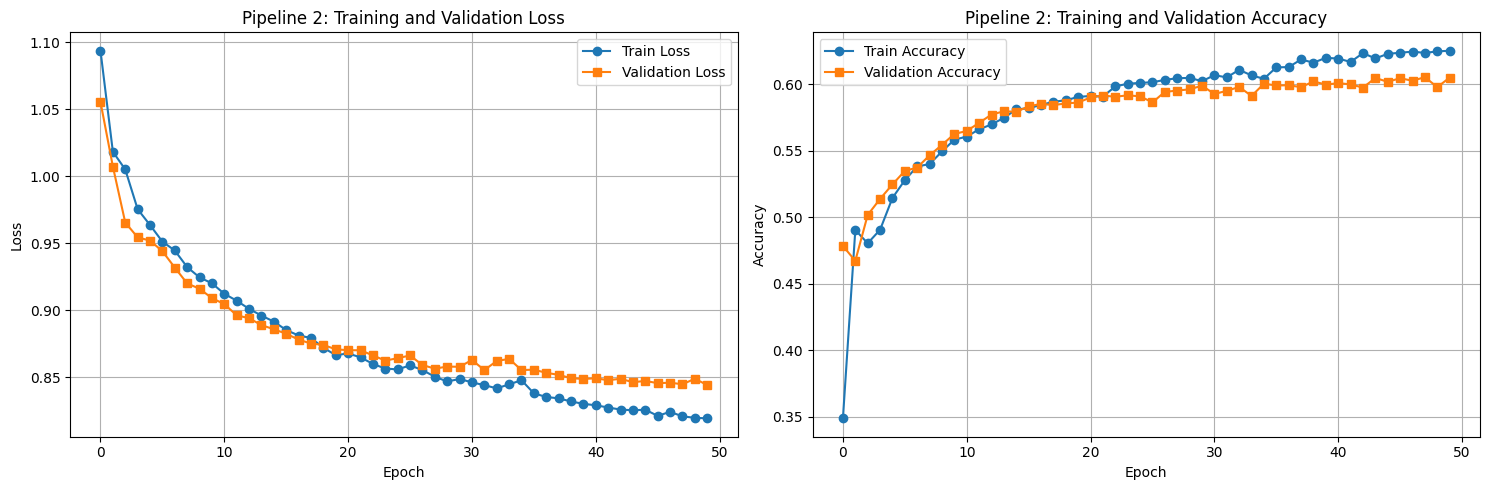

Best validation accuracy: 0.6054 at epoch 48


In [371]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
axes[0].plot(train_losses_p2, label='Train Loss', marker='o')
axes[0].plot(val_losses_p2, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Pipeline 2: Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracies
axes[1].plot(train_accuracies_p2, label='Train Accuracy', marker='o')
axes[1].plot(val_accuracies_p2, label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Pipeline 2: Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(val_accuracies_p2):.4f} at epoch {val_accuracies_p2.index(max(val_accuracies_p2)) + 1}")


TEST SET RESULTS
Test Loss: 0.8516
Test Accuracy: 0.6008

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.63      0.51      0.56      1542
           1       0.52      0.62      0.57      1912
           2       0.69      0.65      0.67      1726

    accuracy                           0.60      5180
   macro avg       0.61      0.60      0.60      5180
weighted avg       0.61      0.60      0.60      5180



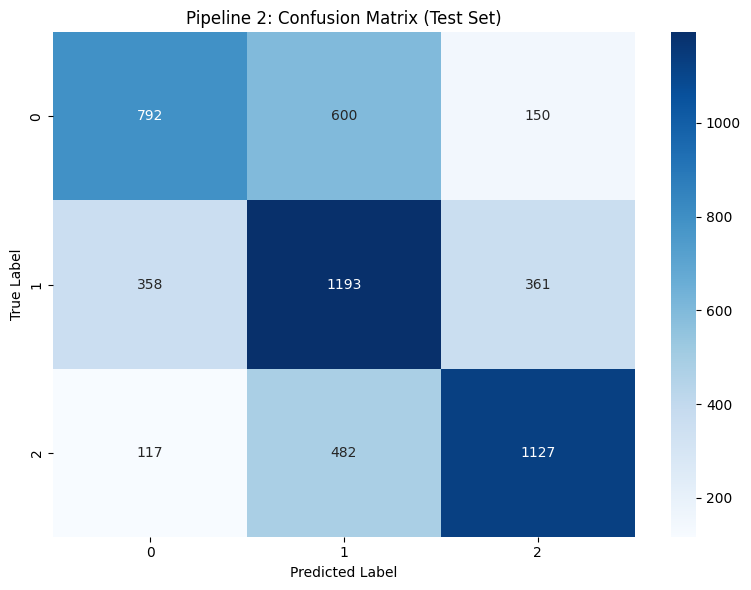

In [372]:
# Evaluate on test set
test_loss_p2, test_accuracy_p2, y_test_pred_p2, y_test_true_p2 = validate(
    mlp_model_p2, test_loader_p2, criterion, device
)

print(f"\n{'='*60}")
print("TEST SET RESULTS")
print(f"{'='*60}")
print(f"Test Loss: {test_loss_p2:.4f}")
print(f"Test Accuracy: {test_accuracy_p2:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test_true_p2, y_test_pred_p2))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_p2 = confusion_matrix(y_test_true_p2, y_test_pred_p2)
sns.heatmap(cm_p2, annot=True, fmt='d', cmap='Blues')
plt.title('Pipeline 2: Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

---
# Pipeline 3: MLP with Embedding Layer from Scratch

## 7. Pipeline 3: MLP with Embedding Layer from Scratch

This pipeline uses:
- **Feature extraction**: Learnable embedding layer trained from scratch
- **Model**: MLP with embedding layer
- **Architecture**: Embedding → Average Pooling → Hidden(128) → ReLU → Dropout → Hidden(64) → ReLU → Dropout → Output
- **Train/Validation Split**: 80/20 split from training data
- **No Pre-trained Embeddings**: Learns embeddings during training

In [373]:
# Build vocabulary from tokens
from collections import Counter

def build_vocabulary(token_lists, min_freq=2):
    """Build vocabulary from token lists."""
    counter = Counter()
    for tokens in token_lists:
        counter.update(tokens)
    
    # Create vocabulary with special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab

# Build vocabulary from training data
vocab = build_vocabulary(train_df['tokens'].tolist(), min_freq=2)
vocab_size = len(vocab)

print(f"Pipeline 3: MLP with Embedding from Scratch")
print("=" * 60)
print(f"Vocabulary size: {vocab_size}")
print(f"First 10 words in vocabulary: {list(vocab.keys())[:10]}")

Pipeline 3: MLP with Embedding from Scratch
Vocabulary size: 11196
First 10 words in vocabulary: ['<PAD>', '<UNK>', 'cooking', 'microwave', 'pizzas', 'yummy', 'plans', 'allowing', 'sub', 'tasks']


In [374]:
# Convert tokens to indices
def tokens_to_indices(token_lists, vocab, max_length=100):
    """Convert token lists to padded index sequences."""
    sequences = []
    for tokens in token_lists:
        indices = [vocab.get(token, vocab['<UNK>']) for token in tokens[:max_length]]
        # Pad sequences
        if len(indices) < max_length:
            indices += [vocab['<PAD>']] * (max_length - len(indices))
        sequences.append(indices)
    return np.array(sequences)

max_length = 100

# Convert all data to indices
X_train_indices = tokens_to_indices(train_df['tokens'].tolist(), vocab, max_length)
X_test_indices = tokens_to_indices(test_df['tokens'].tolist(), vocab, max_length)

print(f"Training data shape: {X_train_indices.shape}")
print(f"Test data shape: {X_test_indices.shape}")
print(f"Max sequence length: {max_length}")
print(f"\nExample sequence (first 10 indices): {X_train_indices[0][:10]}")

Training data shape: (31106, 100)
Test data shape: (5180, 100)
Max sequence length: 100

Example sequence (first 10 indices): [2 3 4 5 0 0 0 0 0 0]


In [375]:
# Define MLP with Embedding Layer
class MLPWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100,
                num_classes=3, padding_idx=0):
        super(MLPWithEmbedding, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        
        # MLP layers using Sequential
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.7),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.6),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.7),
            
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        # Average pooling over sequence length
        pooled = torch.mean(embedded, dim=1)  # (batch_size, embedding_dim)
        
        # Pass through MLP
        out = self.mlp(pooled)
        return out

print("MLP with Embedding model architecture defined!")


MLP with Embedding model architecture defined!


In [376]:
# Prepare data for Pipeline 3
X_train_p3, X_val_p3, y_train_p3, y_val_p3 = train_test_split(
    X_train_indices, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Convert to PyTorch tensors
X_train_p3_tensor = torch.LongTensor(X_train_p3)
y_train_p3_tensor = torch.LongTensor(y_train_p3)
X_val_p3_tensor = torch.LongTensor(X_val_p3)
y_val_p3_tensor = torch.LongTensor(y_val_p3)
X_test_p3_tensor = torch.LongTensor(X_test_indices)
y_test_p3_tensor = torch.LongTensor(y_test)

# Create DataLoaders
train_dataset_p3 = torch.utils.data.TensorDataset(X_train_p3_tensor, y_train_p3_tensor)
val_dataset_p3 = torch.utils.data.TensorDataset(X_val_p3_tensor, y_val_p3_tensor)
test_dataset_p3 = torch.utils.data.TensorDataset(X_test_p3_tensor, y_test_p3_tensor)

batch_size = 10000
train_loader_p3 = DataLoader(train_dataset_p3, batch_size=batch_size, shuffle=True)
val_loader_p3 = DataLoader(val_dataset_p3, batch_size=batch_size, shuffle=False)
test_loader_p3 = DataLoader(test_dataset_p3, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_dataset_p3)}")
print(f"Validation set size: {len(val_dataset_p3)}")
print(f"Test set size: {len(test_dataset_p3)}")
print(f"Batch size: {batch_size}")

Training set size: 24884
Validation set size: 6222
Test set size: 5180
Batch size: 10000


In [377]:
# Initialize model, loss function, and optimizer for Pipeline 3
embedding_dim = 100
mlp_embed_model_p3 = MLPWithEmbedding(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_classes=num_classes,
    padding_idx=vocab['<PAD>']
).to(device)

criterion_p3 = nn.CrossEntropyLoss()
optimizer_p3 = optim.Adam(mlp_embed_model_p3.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
)

print(f"Model architecture:")
print(mlp_embed_model_p3)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_embed_model_p3.parameters())}")
print(f"Embedding layer parameters: {vocab_size * embedding_dim}")

Model architecture:
MLPWithEmbedding(
  (embedding): Embedding(11196, 100, padding_idx=0)
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.6, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.7, inplace=False)
    (12): Linear(in_features=64, out_features=3, bias=True)
  )
)

Total parameters: 1187699
Embedding layer parameters: 1119600


In [378]:
# Train Pipeline 3
num_epochs_p3 = 50
train_losses_p3 = []
val_losses_p3 = []
train_accuracies_p3 = []
val_accuracies_p3 = []

print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs_p3):
    train_loss, train_acc = train_epoch(mlp_embed_model_p3, train_loader_p3, criterion_p3, optimizer_p3, device)
    val_loss, val_acc, _, _ = validate(mlp_embed_model_p3, val_loader_p3, criterion_p3, device)

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    train_losses_p3.append(train_loss)
    val_losses_p3.append(val_loss)
    train_accuracies_p3.append(train_acc)
    val_accuracies_p3.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_p3}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"  Current Learin rate: {current_lr:.6f}")

print("\nTraining completed!")

Starting training...
Epoch [5/50]
  Train Loss: 1.1699, Train Acc: 0.3605
  Val Loss: 1.0934, Val Acc: 0.3717
  Current Learin rate: 0.002500
Epoch [10/50]
  Train Loss: 1.1194, Train Acc: 0.3716
  Val Loss: 1.0991, Val Acc: 0.3717
  Current Learin rate: 0.001250
Epoch [15/50]
  Train Loss: 1.0915, Train Acc: 0.3903
  Val Loss: 1.0896, Val Acc: 0.3737
  Current Learin rate: 0.000625
Epoch [20/50]
  Train Loss: 1.0664, Train Acc: 0.4187
  Val Loss: 1.0580, Val Acc: 0.4148
  Current Learin rate: 0.000625
Epoch [25/50]
  Train Loss: 1.0422, Train Acc: 0.4519
  Val Loss: 1.0116, Val Acc: 0.4757
  Current Learin rate: 0.000625
Epoch [30/50]
  Train Loss: 1.0149, Train Acc: 0.4792
  Val Loss: 0.9790, Val Acc: 0.5146
  Current Learin rate: 0.000625
Epoch [35/50]
  Train Loss: 0.9848, Train Acc: 0.5041
  Val Loss: 0.9534, Val Acc: 0.5354
  Current Learin rate: 0.000625
Epoch [40/50]
  Train Loss: 0.9548, Train Acc: 0.5283
  Val Loss: 0.9314, Val Acc: 0.5535
  Current Learin rate: 0.000625
Epoc

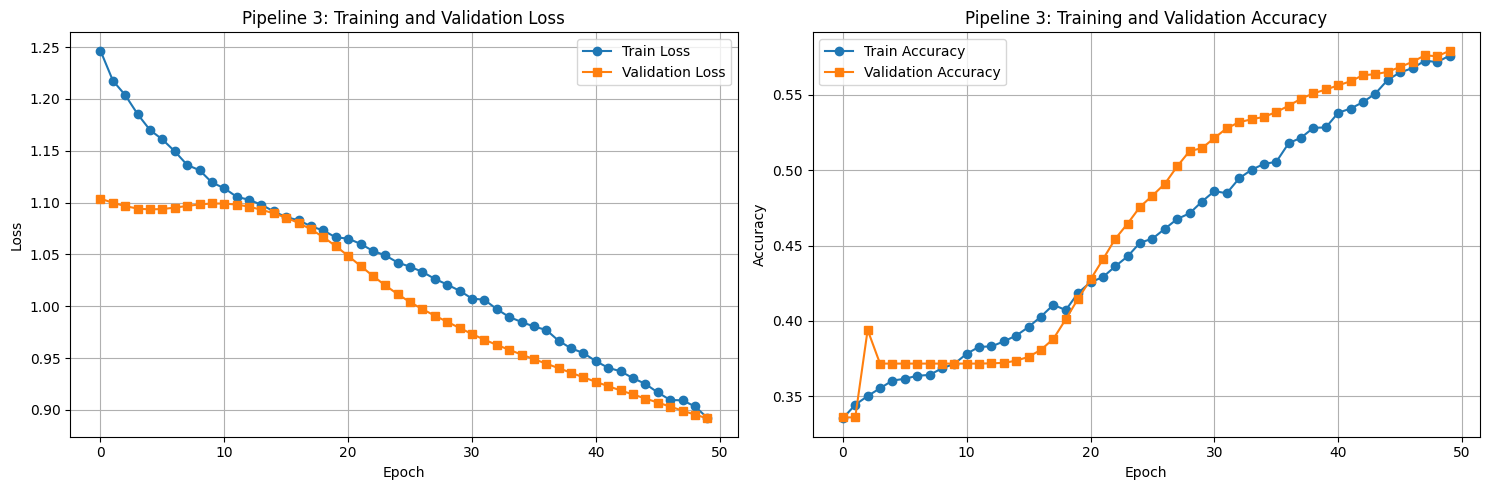

Best validation accuracy: 0.5792 at epoch 50


In [379]:
# Plot training history for Pipeline 3
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
axes[0].plot(train_losses_p3, label='Train Loss', marker='o')
axes[0].plot(val_losses_p3, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Pipeline 3: Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracies
axes[1].plot(train_accuracies_p3, label='Train Accuracy', marker='o')
axes[1].plot(val_accuracies_p3, label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Pipeline 3: Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(val_accuracies_p3):.4f} at epoch {val_accuracies_p3.index(max(val_accuracies_p3)) + 1}")


TEST SET RESULTS
Test Loss: 0.8952
Test Accuracy: 0.5795

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.58      0.53      0.56      1542
           1       0.50      0.56      0.53      1912
           2       0.67      0.64      0.66      1726

    accuracy                           0.58      5180
   macro avg       0.59      0.58      0.58      5180
weighted avg       0.58      0.58      0.58      5180



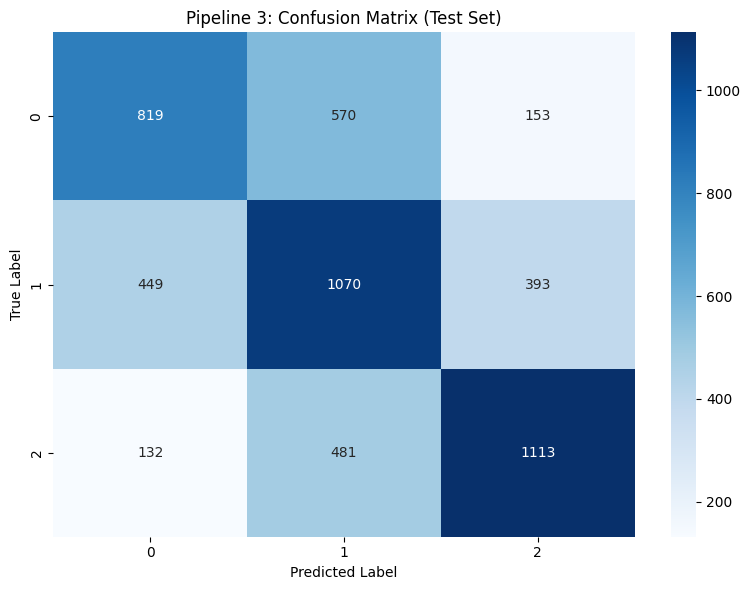

In [380]:
# Evaluate Pipeline 3 on test set
test_loss_p3, test_accuracy_p3, y_test_pred_p3, y_test_true_p3 = validate(
    mlp_embed_model_p3, test_loader_p3, criterion_p3, device
)

print(f"\n{'='*60}")
print("TEST SET RESULTS")
print(f"{'='*60}")
print(f"Test Loss: {test_loss_p3:.4f}")
print(f"Test Accuracy: {test_accuracy_p3:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test_true_p3, y_test_pred_p3))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_p3 = confusion_matrix(y_test_true_p3, y_test_pred_p3)
sns.heatmap(cm_p3, annot=True, fmt='d', cmap='Blues')
plt.title('Pipeline 3: Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

---
# Final Comparison of All Three Pipelines

## 8. Final Comparison and Results

Let's compare all three pipelines side by side on both validation and test sets.


FINAL COMPARISON OF ALL THREE PIPELINES
                          Pipeline  Validation Accuracy  Test Accuracy
 1. Word2Vec + Logistic Regression             0.588717       0.590154
                 2. Word2Vec + MLP             0.605432       0.600772
3. MLP with Embedding from Scratch             0.579235       0.579537


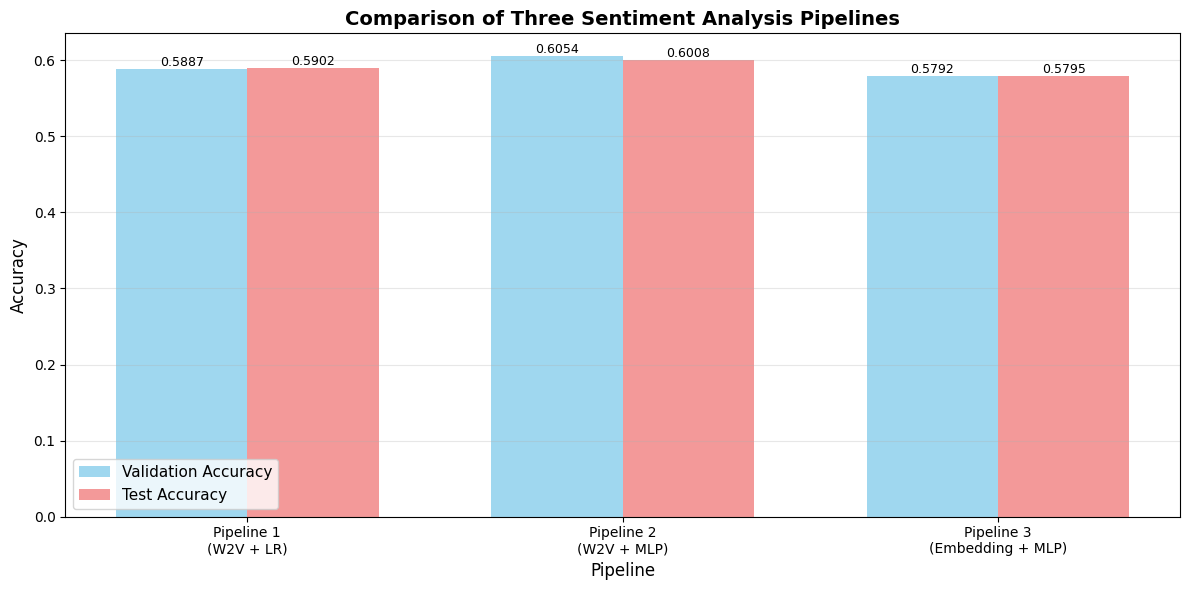


 Best Performing Pipeline: 2. Word2Vec + MLP
   Test Accuracy: 0.6008


In [ ]:
# Create comparison DataFrame
comparison_results = pd.DataFrame({
    'Pipeline': [
        '1. Word2Vec + Logistic Regression',
        '2. Word2Vec + MLP',
        '3. MLP with Embedding from Scratch'
    ],
    'Validation Accuracy': [
        val_accuracy_p1,
        max(val_accuracies_p2),
        max(val_accuracies_p3)
    ],
    'Test Accuracy': [
        test_accuracy_p1,
        test_accuracy_p2,
        test_accuracy_p3
    ]
})

print("\n" + "="*80)
print("FINAL COMPARISON OF ALL THREE PIPELINES")
print("="*80)
print(comparison_results.to_string(index=False))
print("="*80)

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_results['Pipeline']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_results['Validation Accuracy'], width, 
               label='Validation Accuracy', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, comparison_results['Test Accuracy'], width,
               label='Test Accuracy', alpha=0.8, color='lightcoral')

ax.set_xlabel('Pipeline', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Comparison of Three Sentiment Analysis Pipelines', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Pipeline 1\n(W2V + LR)', 'Pipeline 2\n(W2V + MLP)', 
                    'Pipeline 3\n(Embedding + MLP)'], fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Find best pipeline
best_pipeline_idx = comparison_results['Test Accuracy'].idxmax()
best_pipeline = comparison_results.loc[best_pipeline_idx, 'Pipeline']
best_accuracy = comparison_results.loc[best_pipeline_idx, 'Test Accuracy']

print(f"\n Best Performing Pipeline: {best_pipeline}")
print(f"   Test Accuracy: {best_accuracy:.4f}")

## 9. Summary and Insights

### Pipeline Architectures

**Pipeline 1: Word2Vec + Multinomial Logistic Regression**
- Pre-trained Word2Vec embeddings (100 dimensions)
- Document vectors: averaged word embeddings
- Simple multinomial logistic regression classifier
- Fast training, good baseline performance

**Pipeline 2: Word2Vec + MLP**
- Pre-trained Word2Vec embeddings (100 dimensions)
- Document vectors: averaged word embeddings  
- Deep neural network: 4 hidden layers (256 → 34 neurons)
- Dropout regularization (0 to 0.2)
- More expressive than linear model

**Pipeline 3: MLP with Embedding from Scratch**
- Learnable embedding layer (trained end-to-end)
- Sequence processing: average pooling over embeddings
- Deep neural network: 2 hidden layers (256 → 64 neurons)
- Batch Normalization to stabilize training
- Dropout regularization (0.6 to 0.7)
- Harder to maintain to not overfit that why higher dropout and batch norm

### Key Observations

All of the pipelines performed well, those scores are pretty close to each other, but the MLP with word2vec embeddings (Pipeline 2) achieved the highest validation and test accuracy, suggesting that the non-linear modeling capacity of the MLP provided a significant boost over the linear logistic regression model. The MLP with embedding from scratch (Pipeline 3) also performed well, but slightly underperformed compared to Pipeline 2, likely due to the limited training data for learning effective embeddings from scratch. Overall, leveraging pre-trained embeddings combined with a powerful classifier like an MLP seems to be the most effective approach for this multiclass sentiment analysis task.